Stand: 10/2020 | Autor: Fabian

# AWS Sagemaker
Sagemaker ist ein Service von AWS zum trainieren von Machine Learning Modellen.
Hierzu erfüllt Sagemaker unterschiedliche Aufgaben. Eine Teil des Services ist die Bereitstellung von Jupyter Notebook Instanzen, die ganz ähnlich wie Jupyter Notebooks auf einem Laptop verwendet werden können. Die Unterschiede werden in diesem Notebook aufgezeigt.

Im nächsten Teil wird geziegt, wie die Sagemaker API verwendet werden kann, um sklearn und XGB aus den Sagemaker Containern zu verwenden und so Modelle cleverver trainieren zu lassen.


# Einstieg in Sagemaker Notebooks

Ziel dieses Notebooks ist es die Unterschiede zwischen Jupyter auf deinem Laptop und Jupyter in Sagemaker aufzuzeigen.

## Importieren von Paketen

Genau wie auf deinem Notebook, kannst du bereits installierte Pakete importieren. Hier besteht __kein__ Unterschied zwischen der Nutzung von Jupyter auf deinem Laptop oder in Sagemaker.


In [8]:
import pandas as pd
from datetime import datetime

import pickle
import boto3 # Libary für den Zugriff aus AWS Services wie S3
from io import BytesIO

In [2]:
pd.__version__

'1.0.1'

## Sagemaker unterstützt Jupyter Magic
Mit den Magic Commands können Behelfe in der Commandline ausgeführt werden.

In [9]:
! echo hallo

hallo


In [5]:
! pwd

/home/ec2-user/SageMaker


In [3]:
! python --version

Python 3.6.10 :: Anaconda, Inc.


In [6]:
! pip list

Package                            Version            
---------------------------------- -------------------
absl-py                            0.10.0             
alabaster                          0.7.12             
anaconda-client                    1.7.2              
anaconda-project                   0.8.3              
argh                               0.26.2             
asn1crypto                         1.3.0              
astor                              0.8.1              
astroid                            2.4.2              
astropy                            4.0                
atomicwrites                       1.3.0              
attrs                              19.3.0             
autopep8                           1.4.4              
autovizwidget                      0.16.0             
awscli                             1.18.149           
Babel                              2.8.0              
backcall                           0.1.0              
backports.

## Einlesen von Daten
Um ein ML Modell trainieren zu können brauchen wir Daten. Welche unterschiedlichen Wege es gibt, Daten zu verwendet wird in diesem Kapitel aufgezeigt.

### Beispieldatensätze aus dem Internet laden

Daten, welche aus dem Internet geladen werden, können wie auf deinem Laptop auch eingelesen und verarbeitet werden. Hier besteht kein Unterschied zu Sagemaker.

In [10]:
from sklearn.datasets import load_boston

In [11]:
X, y = load_boston(return_X_y=True)

In [17]:
print(f'X: {X.shape}, y: {y.shape}')

X: (506, 13), y: (506,)


In [15]:
y.shape

(506,)

__Pandas:__

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/Fa-bi-an/Intro_Sagemaker/main/data/train.csv')

In [20]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### S3 Buckets

__1. NICHT serialisierte Dateien direkt aus einem Bucket__<br>
Bspw.: `CSV` oder `JSON`-Dateien. <br>
Hierzu muss das Sagemaker Notebook, über die erforderliche ExecutionRole, also Berechtigungen für den Bucket verfügen!
Diese weist man einem Notebook beim anlegen zu.

In [38]:
# S3 Muster

bucket ='<bucket-name>'
data_key = '<path>'
file_name = '<file.type>'
data_path = f's3://{bucket}/{data_key}/{file_name}'

In [37]:
print(f'{data_path}')

s3://<bucket-name>/<path>/<file.type>


In [31]:
df = pd.read_csv(data_path, sep=';', decimal=',')

In [32]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,51,0.0,0.0,0.0,5.0,1,12.0,10.0,0.0,I80.28,...,I8,140.0,1.0,300.0,DE,J67,Z,4.0,101.0,R22
1,81,0.0,0.0,0.0,6.0,2,3.0,3.0,0.0,R00.2,...,R0,502.0,1.0,300.0,DE,F71,B,5.0,301.0,I48
2,57,0.0,0.0,0.0,2.0,2,1.0,0.0,0.0,M76.6,...,M7,908.0,1.0,10.0,DE,I20,H,2.0,101.0,M76
3,11,0.0,0.0,0.0,3.0,2,1.0,0.0,0.0,Q04.6,...,Q0,139.0,1.0,34.0,DE,B18,C,6.0,940.0,G91
4,35,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,O02.1,...,O0,NaN,1.0,15.0,DE,O40,Z,5.0,101.0,O02


__2. SERIALISIERTE Dateien__<br>
Bspw.: `pickle`-Dateien.


In [ ]:
import pickle
import boto3
from io import BytesIO
import pandas as pd

In [ ]:
# S3 Muster
bucket ='<bucket-name>'
data_key = '<path>'
file_name = '<file.type>'

In [ ]:
s3 = boto3.resource('s3')
with BytesIO() as data:
    s3.Bucket(bucket).download_fileobj(f"{data_key}/{file_name}", data)
    data.seek(0)    # move back to the beginning after writing
    df = pickle.load(data)

## Verarbeiten von Daten

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
reg = LinearRegression()

In [49]:
reg.fit(X_train,y_train)

LinearRegression()

In [51]:
preds = reg.predict(X_test)

In [54]:
preds_df = pd.DataFrame(list(zip(preds, y_test)), 
               columns =['Preds', 'y_test']) 

In [55]:
preds_df.head()

,Preds,y_test
0,28.534695,23.6
1,36.618701,32.4
2,15.637511,13.6
3,25.501450,22.8
4,18.709673,16.1


In [50]:
reg.score(X_test,y_test)

0.7261570836552478

## Visualisiern von Daten

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Vorhersage')

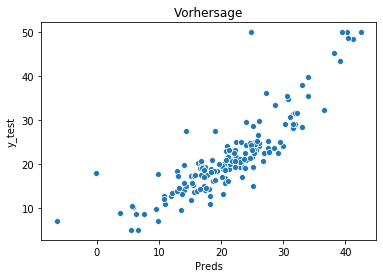

In [62]:
sns.scatterplot(x="Preds", y="y_test", data=preds_df )
plt.title('Vorhersage')

## Speichern von Dateien

__1.Speicher von nicht serialisierte Dateien mit Pandas direkt in S3__

In [85]:
# https://stackoverflow.com/questions/38154040/save-dataframe-to-csv-directly-to-s3-python

from io import StringIO # python3; python2: BytesIO 
import boto3

In [90]:
bucket = 'pista-2020-3' # already created on S3
csv_buffer = StringIO()
preds_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'preds_df.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '23AF1645F669DD76',
  'HostId': 'GGHNjIVPugLcYMem+eVJKXyLUQh7Db+WG/6AQdqNS1XprvRH65WF52TU+VgILKqKKOX6HkD0uPQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'GGHNjIVPugLcYMem+eVJKXyLUQh7Db+WG/6AQdqNS1XprvRH65WF52TU+VgILKqKKOX6HkD0uPQ=',
   'x-amz-request-id': '23AF1645F669DD76',
   'date': 'Thu, 15 Oct 2020 15:12:57 GMT',
   'x-amz-version-id': '5t3WhFY.xXKy2z8Vg9xjvfi_k86PY2bt',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"6f884b755f29627ad966e45ae82334cd"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"6f884b755f29627ad966e45ae82334cd"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '5t3WhFY.xXKy2z8Vg9xjvfi_k86PY2bt'}

__2. lokal Speichern und danach zu S3 hochladen__

In [76]:
import sagemaker

In [74]:
session = sagemaker.Session()

In [77]:
preds_df.to_csv('preds.csv')

In [82]:
# Datei lokal vorhanden
! ls

Introduction_Sagemaker_Notebooks_de.ipynb  lost+found


In [79]:
# Verwende die Methode upload_data zum hochladen von lokalen Dateien in S3
session.upload_data(path='preds.csv',bucket='<bucket-name>')

's3://pista-2020-3/data/preds.csv'

In [83]:
# Löschen der lokalen Datei
! rm preds.csv

rm: cannot remove ‘preds.csv’: No such file or directory


In [81]:
! ls

Introduction_Sagemaker_Notebooks_de.ipynb  lost+found
